# NLP Analysis of World Cup 2022 Tweets

### About the dataset

This dataset contains 30,000 tweets from the first day of the FIFA World Cup 2022. The dataset includes tweets in English containing the hashtag #WorldCup2022

The dataset was created using the Snscrape and the cardiffnlp/twitter-roberta-base-sentiment-latest model in Hugging Face Hub.

https://www.kaggle.com/datasets/tirendazacademy/fifa-world-cup-2022-tweets

### Goal of this project

The goal of this project is to train a classification model for sentiment classification and to explore interesting sentiments expressed by tweeters at the onset of the world cup. 

### Exploratory Data Analysis

In [2]:
# Import Libraries
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\71062489\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Import Dataset
tweets_df = pd.read_csv('fifa_world_cup_2022_tweets.csv')

print(tweets_df.columns)

Index(['Unnamed: 0', 'Date Created', 'Number of Likes', 'Source of Tweet',
       'Tweet', 'Sentiment'],
      dtype='object')


We know that there were protests against hosting the World Cup in Qatar, whether due to FIFA corruption, human rights abuses in Qatar, the banning of alcohol sales in the stadiums, or the banning of the OneLove armband. 

Before we train our model, it will be interesting to dig a little deeper into what the negative tweets mean. 

[Text(0.5, 1.0, 'World Cup Tweet 2022 Sentiment')]

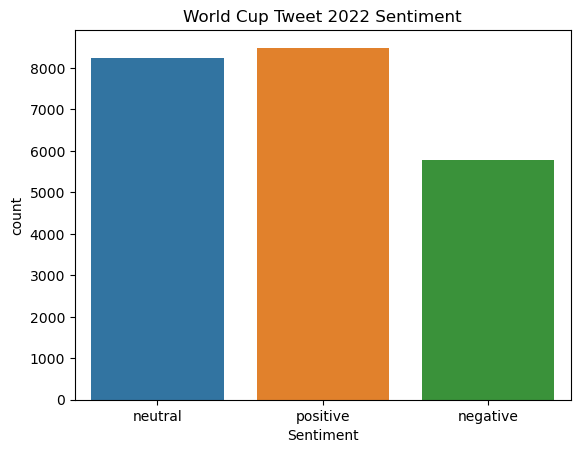

In [28]:
# See distribution of sentiment among tweet dataset. 
sns.countplot(x=tweets_df["Sentiment"]).set(title='World Cup Tweet 2022 Sentiment')

We see that there are slightly more neutral and positive tweets than negative tweets. 

[Text(0.5, 1.0, 'Most Liked Tweets World Cup 2022 Sentiment')]

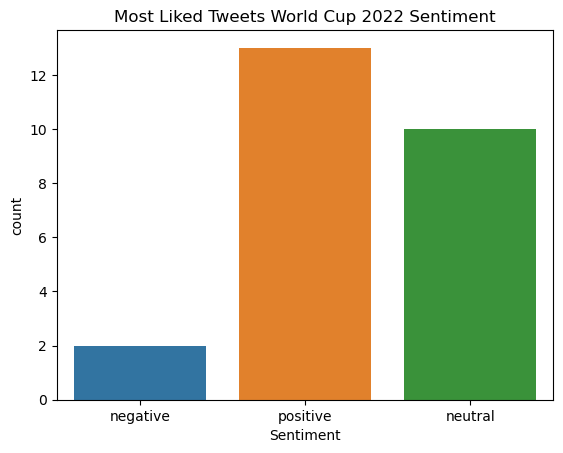

In [5]:
most_liked_tweets = tweets_df.loc[tweets_df['Number of Likes'] >= 1000]

sns.countplot(x=most_liked_tweets["Sentiment"]).set(title='Most Liked Tweets World Cup 2022 Sentiment')

However, when we look at the tweets that recieved a 1000 likes or more, we can see that only 2 of them were negative. Assumming more people doll out likes than write posts, perhaps the wider twitter audience has more positive sentiment about the World Cup than negative. 

What are the two most popular negative tweets? 

In [6]:
# The two most liked negative tweets
print(most_liked_tweets['Tweet'].loc[most_liked_tweets['Sentiment']=='negative'])

212    "It's Palestine..."\n\nLebanese fans refuse to...
677    @LinahAlsaafin Never forget when #IsraeliApart...
Name: Tweet, dtype: object


#### Most Liked Negative Tweets 

They appear to be about the Israeli–Palestinian conflict:

"It's Palestine...Lebanese fans refuse to be interviewed by an Israeli TV reporter after he said that he is from 'Israel' at #WorldCup2022 in Qatar."

"Never forget when #IsraeliApartheid murdered 4 children playing football in Gaza."



#### Tweet sentiment as game time approached

[Text(0.5, 1.0, 'Sentiment Leading up to the Game')]

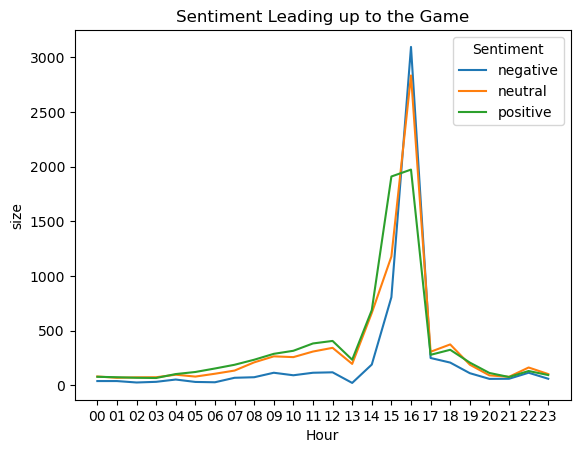

In [7]:
# Create Dataframe to get number of tweets per hour grouped by sentiment. 
time_df = tweets_df[['Date Created', 'Sentiment']].copy()
time_df['Date Created'] = pd.to_datetime(time_df['Date Created']) 
time_df['Hour'] = time_df['Date Created'].dt.strftime('%H')
time_df = time_df.drop('Date Created', axis=1)

time_df = time_df.groupby(["Hour", "Sentiment"], as_index=False)["Sentiment"].size()

sns.lineplot(x='Hour', y='size', hue='Sentiment', data=time_df).set(title='Sentiment Leading up to the Game')

Based on our plot, it looks like the most tweets took place in the 5 hours leading up to the first game, which started at 19:00 CST. 

4 hours before the game, it looks like negative and neutral tweets spiked. This is probably because tweeters who want to express negative views are more likely to tweet right before the game (in hopes of having their tweet trending) and because businesses want to promote themselves/products close to gametime. 

Positive tweets had a spike as well, probably due to excitement leading up to the game. 

### Sentiment Classification Model

Now that we've seen a few interesting things about the data, let's create our Sentiment Classification model. 

#### 1. Prepare the Dataset: Tokenization, Stopwords, and Stemming 

<b>Tokenization</b>: The process of segmenting running text into sentences and words. In essence, it’s the task of cutting a text into pieces called tokens, and at the same time throwing away certain characters, such as punctuation

<b>Stopwords</b>: Getting rid of common language articles, pronouns and prepositions such as “and”, “the” or “to” in English.

<b>Stemming</b>: The process of slicing the end or the beginning of words with the intention of removing affixes (lexical additions to the root of the word).

Definition Source: https://towardsdatascience.com/your-guide-to-natural-language-processing-nlp-48ea2511f6e1

In [11]:
# Import Required Libraries

import nltk
import re
nltk.download('stopwords')
stemmer = nltk.SnowballStemmer("english")
from nltk.corpus import stopwords
import string
stopword=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\71062489\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# Tokenize & Stem Tweets
# Remove Stop words from tweets

def clean(tweet):
    tweet = str(tweet).lower()
    tweet = re.sub('\[.*?\]', '', tweet)
    tweet = re.sub('https?://\S+|www\.\S+', '', tweet)
    tweet = re.sub('<.*?>+', '', tweet)
    tweet = re.sub('[%s]' % re.escape(string.punctuation), '', tweet)
    tweet = re.sub('\n', '', tweet)
    tweet = re.sub('\w*\d\w*', '', tweet)
    tweet = [word for word in tweet.split(' ') if word not in stopword]
    tweet =" ".join(tweet)
    tweet = [stemmer.stem(word) for word in tweet.split(' ')]
    tweet =" ".join(tweet)
    return tweet

tweets_df['Tweet'] = tweets_df['Tweet'].apply(clean)

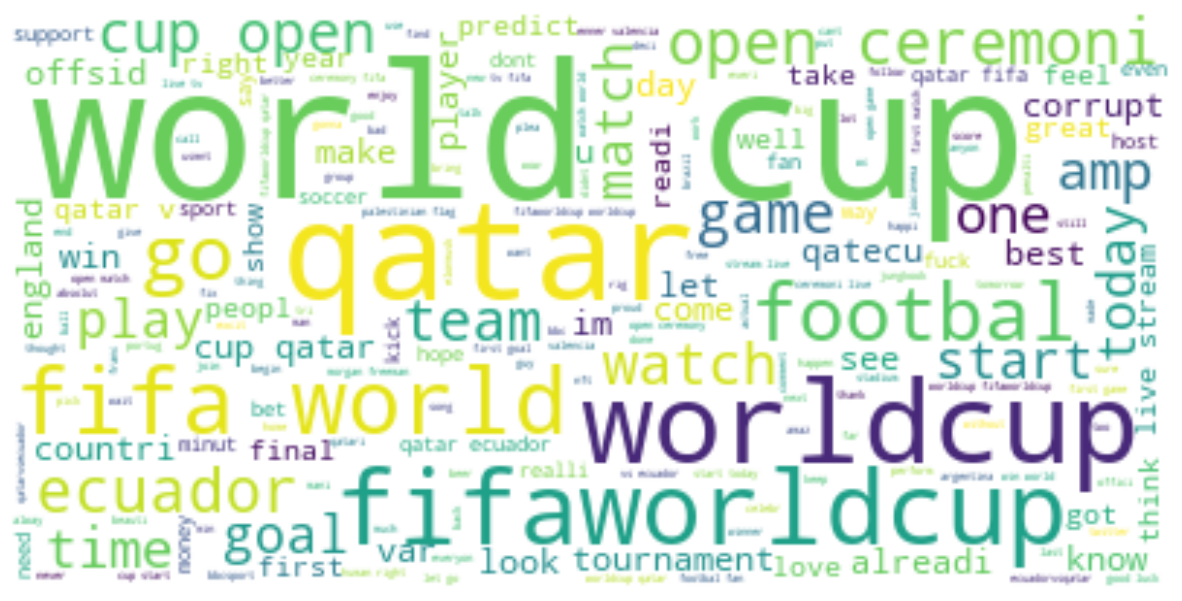

In [19]:
# Create Word Cloud of Cleaned Data
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
text = " ".join(i for i in tweets_df['Tweet'])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### 2. Text Vectorization

<b>Text Vectorization</b>: The process of converting text into numerical representation



In [21]:
x = np.array(tweets_df["Tweet"])
y = np.array(tweets_df["Sentiment"])

# Text Vectorization
cv = CountVectorizer()
X = cv.fit_transform(x)

# Create Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#### 3. Train the Text Classification Model

In [22]:
from sklearn.linear_model import PassiveAggressiveClassifier
model = PassiveAggressiveClassifier()
model.fit(X_train,y_train)

PassiveAggressiveClassifier()

#### 4. Test Text Classification Model

In [25]:
# See how well model performs on our test set
y_pred = model.predict(X_test)

In [27]:
# Accuracy of our model on our test set
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy Score of Passive Aggresive Scassifier: {round(accuracy*100,2)}%')

Accuracy Score of Passive Aggresive Scassifier: 66.42%


Test your own tweet! Invent a tweet about the world cup and the model will predict if your sentiment is positive, negative, or neutral!

In [24]:
# Create a world cup tweet and the model will predict if your sentiment is postive or negative! 
user = input("Enter a Text: ")
data = cv.transform([user]).toarray()
output = model.predict(data)
print(output)

['neutral']


### Conclusion

This was a great introduction to the process for created and NLP classification model. 

To take this project further, I would like to analyze sentiment over the whole time of the world cup. Since this dataset only contains tweets from the first 24 hours, we cannot understand how sentiment changed over the course of the tournament. 

I would also like to do analyze grouped by different hashtags. For example, analyze, via tweet sentiment, if more people favor Messi or Ronaldo. 